In [3]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = pd.read_csv("../data/train.csv", index_col='Id')
test_data= pd.read_csv("../data/test.csv", index_col='Id')

In [4]:
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y=X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# spliting the data into train and test
X_train_full,X_valid_full,y_train,y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

categorial_cols = [cols for cols in X_train_full.columns if X_train_full[cols].nunique() < 10 and X_train_full[cols].dtype == 'object']
numerical_cols = [cols for cols in X_train_full.columns if X_train_full[cols].dtype in ['int64','float64']]
cols = categorial_cols + numerical_cols
X_train = X_train_full[cols].copy()
X_valid = X_valid_full[cols].copy()
X_test = test_data[cols].copy()

X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Preprocessing the data for numerical values and Categorial values
using Simpleimputer and OneHotEncoder with the help of pipeline and transfromer

In [16]:
numerical_transformer = SimpleImputer(strategy='median')
categorial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])
# making a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorial_transformer, categorial_cols)
])

# finetuning n_estimators

In [17]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=n_estimators, learning_rate = 0.05))
    ])
    score = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    return score.mean()

In [7]:
result = {}
for i in range(1,11):
    result[100*i] = get_score(100*i)

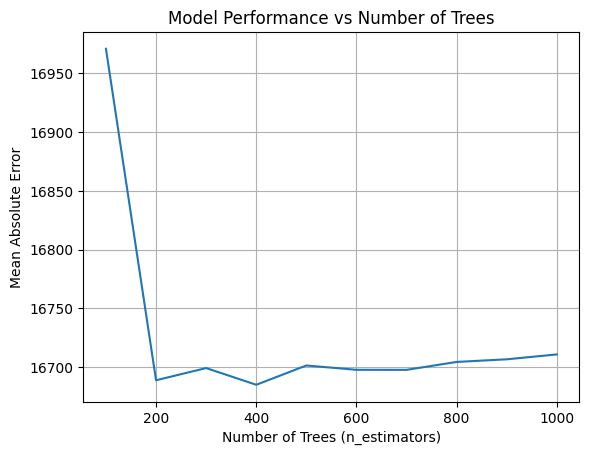

Best n_estimators: 400


In [15]:
# Ploting the graph of Model performance vs Number of trees(n_estimators)
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(result.keys()), list(result.values()))
plt.title("Model Performance vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.show()
best_n = min(result, key=result.get) 
print(f"Best n_estimators: {best_n}")

# Finetuning learning_rate

In [10]:
import numpy as np
learning_rates = np.linspace(0.01, 0.2, 70)  
results = {}

for lr in learning_rates:
    model = XGBRegressor(n_estimators=best_n, learning_rate=lr, early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    results[lr] = mae

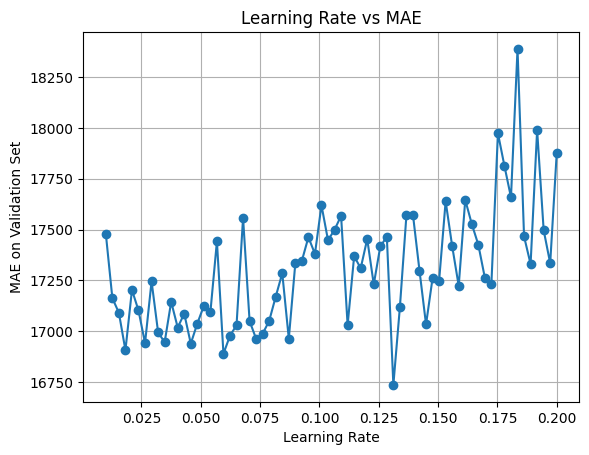

Best learning rate: 0.13115942028985508


In [11]:
plt.plot(results.keys(), results.values(), marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("MAE on Validation Set")
plt.title("Learning Rate vs MAE")
plt.grid(True)
plt.show()

best_lr = min(results, key=results.get)
print(f"Best learning rate: {best_lr}")

# Defining and training our model

In [12]:
my_model = XGBRegressor(n_estimators=best_n, learning_rate = best_lr, early_stopping_rounds=5)

# Fit with early stopping
my_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,5
,enable_categorical,False
,eval_metric,None


In [13]:
pred = my_model.predict(X_valid)
mea = mean_absolute_error(y_valid, pred)
print(mea) 

16735.298828125


# For testing the model on test.csv and storing the output in a csv file

In [ ]:
'''predictions = my_model.predict(X_test)
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)'''